# Stock Analysis Dashboard

When researching potential investments it is important to obtain an understanding of the asset's behaviour over time. This may include metrics relating to the performance of a company. Or it may simply involve looking at the price trends during some time window. 

The code below presents different views of a stock's performance. Although this is useful, it is not the only information that should be taken into consideration when making financial decisions. Additional research should be done by based on news and other events.

In [1]:
!pip install yfinance
!pip install beautifulsoup4
!pip install requests

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Users\mkiri\Anaconda3\python.exe -m pip install --upgrade pip' command.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Users\mkiri\Anaconda3\python.exe -m pip install --upgrade pip' command.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Users\mkiri\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yfinance as yf
import pandas_datareader as pdr

from bs4 import BeautifulSoup
import requests
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

### Summary of Asset Performance

The code below presents a simply summary of asset performance. The data is obtained using Yahoo Finance. Only metrics that I have found useful in the past are included. 

In [3]:
# Constants

# List of metrics that may be useful when examining asset performance
METRICS = {'category': 'Category', 'sector': 'Sector', 'previousClose': 'Prev Close', 
           'fiveYearAverageReturn': '5 Yr Avg Ret', 'dividendRate': 'Dividend', 
           'beta': 'Beta', 'heldPercentInsiders': '% Insiders'}

In [4]:
# Helper functions

# Pull data for selected ticker
def get_ticker_obj(tick):
    return yf.Ticker(ticker)

# Get time window from user-defined range
def get_time_period(label):
    last = date.today()
    # Use provided string to get number of days (delta)
    switcher = {
        "1 day": 1,
        "5 days": 5,
        "1 month": 30,
        "3 months": 90,
        "6 months": 180,
        "1 year": 365,
        "2 years": 730,
        "3 years": 1095
    }
    delta = switcher.get(label, "Invalid time range")
    # Use current date and delta to get beginning of time window
    first = (last - timedelta(days=delta))
    return first.strftime('%Y-%m-%d'), last.strftime('%Y-%m-%d')

# Generate asset performance summary 
def get_performance_summary(tick_obj, time_period):
    # Start/end date for time window of interest
    start_date, end_date = get_time_period(time_period)
    
    # Get symbol
    ticker = tick_obj.info['symbol']
        
    # Load metrics into dataframe for easy handling
    df = pd.DataFrame(columns=['Info', 'Value'])
    k = list(METRICS.keys())
    for i in range(len(k)):
        # Check if metric exists for this asset type
        if k[i] in tick_obj.info and tick_obj.info[k[i]]!=None:
            # Store metric value
            df.loc[i] = [METRICS[k[i]], tick_obj.info[k[i]]]

    # Set up dashboard
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
    fig.suptitle(ticker.upper()+" Performance Summary")

    # Create table with all available metrics
    ax1 = fig.add_subplot(gs[0])
    bbox=[0, 0, 1, 1]
    ax1.axis('off')
    mpl_table = ax1.table(cellText = df.values, bbox=bbox, colLabels=df.columns)

    # Historical adjusted close price
    ax2 = fig.add_subplot(gs[1])
    hist = pdr.DataReader(ticker, 
                           start=start_date, 
                           end=end_date, 
                           data_source='yahoo')['Adj Close']
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Adj Close $')
    ax2.set_title('Historical Price ('+time_period+')')
    ax2.plot(hist)
    fig.autofmt_xdate()

In [5]:
# Get info for selected stock
ticker = "tsla"
time_period = "1 month"

tick_obj = get_ticker_obj(ticker)

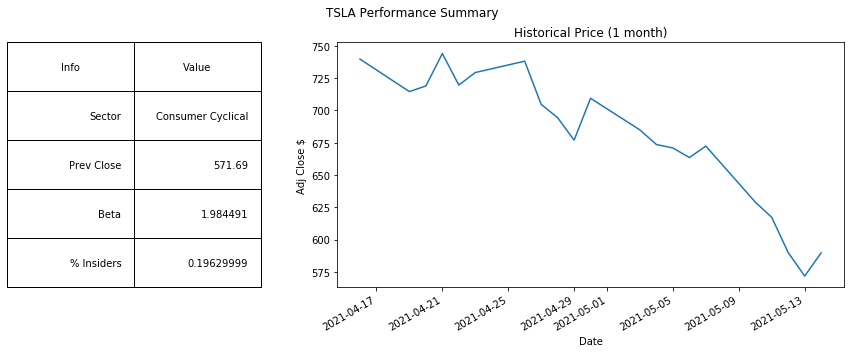

In [6]:
get_performance_summary(tick_obj, time_period)

### ETF Holdings

An ETF is a basket of assets and consists of a collection of stocks and bonds. ETFs are offered by many fund providers. These companies design ETFs to track the performance of a particular index or industry, and then sell shares of those funds to investors. Therefore, when buying an ETF, you are not purchasing individual shares of a company.

When choosing an ETF there are many considerations. While some metrics are captured in the previous section, it does not show the specific composition or holdings of an ETF. The code below scrapes this information from Yahoo Finance.

In [7]:
# Helper function to scrape holdings info from Yahoo Finance
def get_etf_holdings(tick_obj):
    # Check whether the asset is an ETF
    if tick_obj.info['quoteType']!='ETF':
        print("Asset is not an ETF. No holding info available.")
        return
    
    # Get symbol
    ticker = tick_obj.info['symbol']
    
    # Scrape Yahoo Finance page for that asset
    url = "https://ca.finance.yahoo.com/quote/"+ticker+"/holdings?p="+ticker
    r = requests.get(url).text
    soup = BeautifulSoup(r,'html.parser')
    
    # Find all table tags, on the holdings page there should only be one tbody tag
    alldata = soup.find_all("tbody")

    # Find all 'tr' tags
    try:
        table1 = alldata[0].find_all("tr")
    except:
        table1=None

    holdings = [] # Store extracted holdings info
    for i in range(0,len(table1)):
        try:
            # Find all 'td' tags and extract text
            td = table1[i].find_all("td")
            holdings.append([td[0].text, td[1].text, td[2].text])
        except:
            table1_td = None 
    display(pd.DataFrame(holdings, columns=["Name","Symbol","% Assets"]))

In [8]:
ticker = "gdx"

tick_obj = get_ticker_obj(ticker)

get_etf_holdings(tick_obj)

,Name,Symbol,% Assets
0,Newmont Corp,NEM,15.45%
1,Barrick Gold Corp,ABX.TO,11.69%
2,Franco-Nevada Corp,FNV.TO,8.23%
3,Wheaton Precious Metals Corp,WPM.TO,5.75%
4,Newcrest Mining Ltd,NCM.AX,5.28%
5,Agnico Eagle Mines Ltd,AEM.TO,4.56%
6,Kirkland Lake Gold Ltd,KL.TO,3.37%
7,Northern Star Resources Ltd,NST.AX,3.19%
8,Kinross Gold Corp,K.TO,3.01%
9,Anglogold Ashanti Ltd ADR,AU.JO,2.92%


### Plot Price Trend

The code above shows metrics summarizing the performance of a specific stock or ETF; however, it is also useful to compare the behaviour of multiple assets. The code below takes a list of asset tickers/symbols (and the SP500 index) and pulls the historical price data. This data is visualized, along with the percentage change of the price during the time window.

In [9]:
# Helper function to get price trend
def get_price_trend(ticker_list, time_period):
    # Start/end date for time window of interest
    start_date, end_date = get_time_period(time_period)
    
    # Get close price for all tickers + SP500
    all_tickers = [x.upper() for x in ticker_list] + ['^GSPC']
    hist = pdr.DataReader(all_tickers, 
                           start=start_date, 
                           end=end_date, 
                           data_source='yahoo')['Adj Close']
    # Calculate percentage change of price during time window
    pct_chg = (hist-hist.iloc[0]).divide(hist.iloc[0]) * 100
    
    # Set up dashboard
    fig = plt.figure(figsize=(15,5))
    plt.suptitle('Price History ('+time_period+')')

    # Plot historical adjusted close price
    ax1 = fig.add_subplot(121)
    ax1.set_title('Adjusted Close')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adj Close $')
    hist.plot(y=all_tickers, ax=ax1, legend=False)

    # Plot percentage change
    ax2 = fig.add_subplot(122)
    ax2.set_title('Percentage Change in Price')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('% Change')
    pct_chg.plot(y=all_tickers, ax=ax2, legend=False)
    
    # Formatting
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)
    fig.autofmt_xdate()

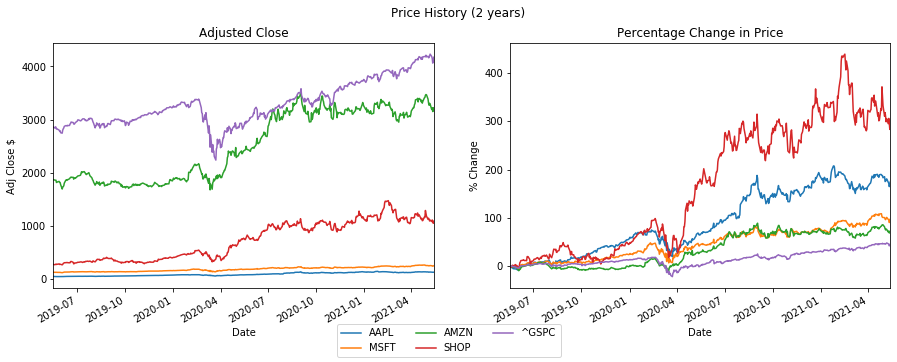

In [10]:
sym = ['aapl','msft','amzn','shop']
time_period = '2 years'
get_price_trend(sym, time_period)